*Importing required libraries*

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from time import sleep
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus.reader.tagged import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mayko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
film_number = 3000

In [3]:
def parse_json_column(column, re_string):
  edited = np.array([])
  for i in column:
    # print(i)
    word_line = ''
    i = i.split(',')
    for j in i:
      j = j.lower()
      # print(j)
      match = re.search(re_string, j)
      # print(match)
      if match:
        word_line += f'{match.group(1)} '
        # print(match.group(1))
    edited = np.append(edited, [word_line])
    # print(edited)
  return edited

---
**CONTENT-BASED RECOMENDATIONS**
---
---


A content-based recommendation is a type of recommendation system that suggests items based on **the similarity of the items**.

The algorithm for constructing a recommendation is quite simple: first we will select each movie's key features, vectorize them and calculate the similarity aka cosine distance for each pair of films.

We will recommend films that are most similar (with the highest cosine distance) to the target.

*Loading required datasets*

In [23]:
meta = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\movies_metadata.csv')
meta['id'] = meta['id'].astype(str)
meta['id'] = meta.index
meta = meta.iloc[0:film_number + 1]
meta.head()

C:\Users\mayko\AppData\Local\Temp\ipykernel_14500\3434519917.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,1,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,2,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,3,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,4,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [11]:
keywords = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\keywords.csv')
# keywords['id'] = keywords['id'].astype(str)
keywords['id'] = keywords.index
keywords = keywords.iloc[0:film_number + 1]
keywords['keywords'] = parse_json_column(keywords['keywords'], "'([^']*)'\s*}")
keywords.head()

,id,keywords
0,0,jealousy toy boy friendship friends rivalry bo...
1,1,board game disappearance new home recluse gian...
2,2,fishing best friend duringcreditsstinger old men
3,3,based on novel interracial relationship single...
4,4,baby midlife crisis confidence aging daughter ...


In [6]:
credits = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\credits.csv')
# credits['id'] = credits['id'].astype(str)
credits['id'] = credits.index
credits = credits.iloc[0:film_number + 1]
actors = parse_json_column(credits['cast'], "'name': '([^']*)'")
credits['actors'] = actors
credits.head()
# it takes too much time to process this table and for many people actors are not an important feature when choosing a movie
# it does not work for ryan gosling though)))
# UPD actors are DEFINETELY not good for cb

,cast,crew,id,actors
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",1,robin williams jonathan hyde kirsten dunst bra...
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",2,walter matthau jack lemmon ann-margret sophia ...
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",3,whitney houston angela bassett loretta devine ...
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",4,steve martin diane keaton martin short kimberl...
5,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",5,al pacino robert de niro val kilmer jon voight...


We will use only text characteristics as key features for calculating cosine distances, because (in my humble opinion),in reality films are most often compared by their plot and ideas, not by numerical indicators (like box office receipts or even ratings). However, we can use non-text features to filter recommendations based on text features (as will be shown later).

Specifically, we will use these features:
* **Genres:** the most obvious feature to calculate simularity.
* **Overview:** a brief description of the movie's plot.
* **Keywords:** tags that describe the main aspects of the movie.





In [24]:
rec_data = meta[['id', 'title', 'genres', 'adult','overview']]
rec_data = rec_data.fillna('')
rec_data = pd.merge(rec_data, keywords, on=['id'], how='left')
rec_data['genres'] = parse_json_column(rec_data['genres'], "'name': '([^']*)'")
rec_data.head()

,id,title,genres,adult,overview,keywords
0,0,Toy Story,animation comedy family,False,"Led by Woody, Andy's toys live happily in his ...",jealousy toy boy friendship friends rivalry bo...
1,1,Jumanji,adventure fantasy family,False,When siblings Judy and Peter discover an encha...,board game disappearance new home recluse gian...
2,2,Grumpier Old Men,romance comedy,False,A family wedding reignites the ancient feud be...,fishing best friend duringcreditsstinger old men
3,3,Waiting to Exhale,comedy drama romance,False,"Cheated on, mistreated and stepped on, the wom...",based on novel interracial relationship single...
4,4,Father of the Bride Part II,comedy,False,Just when George Banks has recovered from his ...,baby midlife crisis confidence aging daughter ...


Oh, it seems the overview column is very different from the other text columns.

In order to calculate the cosine distance as much as possible, we need to vectorize text features. And before that, we need to pre-process the text (in particular the overview column, because the rest of the features have already been processed): remove stop words, tokenize and lemmatize texts.

*In theory, we could use TFIDF to leave only the most important words that would characterize the film the most, but for the purposes of this project I don’t think that’s necessary.*

In [25]:
overview_edited = np.array([])
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
for i in rec_data['overview']:
  i = i.lower()
  i = re.sub(r'[^\w\s]', '', i)
  i = re.sub(r'\d', '', i)
  tokens = word_tokenize(i)
  lemmas = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
  overview_edited = np.append(overview_edited, [' '.join(lemmas)])
rec_data['overview'] = overview_edited
rec_data['overview'].head()

0    led woody andys toy live happily room andys bi...
1    sibling judy peter discover enchanted board ga...
2    family wedding reignites ancient feud nextdoor...
3    cheated mistreated stepped woman holding breat...
4    george bank recovered daughter wedding receive...
Name: overview, dtype: object

In [26]:
rec_data['combined'] = rec_data[['genres', 'overview', 'keywords']].apply(lambda x: ' '.join(x), axis=1)
rec_data.head()

,id,title,genres,adult,overview,keywords,combined
0,0,Toy Story,animation comedy family,False,led woody andys toy live happily room andys bi...,jealousy toy boy friendship friends rivalry bo...,animation comedy family led woody andys toy l...
1,1,Jumanji,adventure fantasy family,False,sibling judy peter discover enchanted board ga...,board game disappearance new home recluse gian...,adventure fantasy family sibling judy peter d...
2,2,Grumpier Old Men,romance comedy,False,family wedding reignites ancient feud nextdoor...,fishing best friend duringcreditsstinger old men,romance comedy family wedding reignites ancie...
3,3,Waiting to Exhale,comedy drama romance,False,cheated mistreated stepped woman holding breat...,based on novel interracial relationship single...,comedy drama romance cheated mistreated stepp...
4,4,Father of the Bride Part II,comedy,False,george bank recovered daughter wedding receive...,baby midlife crisis confidence aging daughter ...,comedy george bank recovered daughter wedding...


Its time to vectorize our features and calculate cosine distances!

*Note: cosine distance = 1 means that the film was compared with itself*

In [27]:
cv = CountVectorizer()
main_count_matrix = cv.fit_transform(rec_data['combined'])
cosine_sim = cosine_similarity(main_count_matrix)
cosine_sim

array([[1.        , 0.05445832, 0.03136122, ..., 0.0736321 , 0.        ,
        0.04216162],
       [0.05445832, 1.        , 0.0354385 , ..., 0.02773501, 0.        ,
        0.        ],
       [0.03136122, 0.0354385 , 1.        , ..., 0.03194383, 0.        ,
        0.03658197],
       ...,
       [0.0736321 , 0.02773501, 0.03194383, ..., 1.        , 0.06741999,
        0.02862992],
       [0.        , 0.        , 0.        , ..., 0.06741999, 1.        ,
        0.03860457],
       [0.04216162, 0.        , 0.03658197, ..., 0.02862992, 0.03860457,
        1.        ]])

Now, to the recomendation!!!

In [28]:
def content_based_recommendation(movie_id, count):
    target_movie = rec_data.loc[rec_data['id'] == movie_id].values.tolist()[0]
    target_genres = target_movie[2].split()
    target_adult = target_movie[3]
    similar_movies = list(enumerate(cosine_sim[movie_id]))
#     first we sort movies by their simularity
    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]
    rec_movies = []
    for m, s in sorted_similar_movies:
        try:
            info = rec_data.loc[rec_data['id'] == m].values.tolist()[0]
            info_genres = info[2].split()
            info_adult = info[3]
            k = 0
#            after the first step? we need to filter our results
#            here we filter our results by adult and genres (we will only recommend films which have more than half of their genres the same)
#            (later i will show you what happend if we do not filter out results)
            for g in info_genres:
                if g in target_genres:
                    k += 1
            if k / len(target_genres) >= 0.5:
                if info_adult == target_adult:
                        rec_movies.append([info[0], info[1], info[2], info[3], s])
        except Exception:
            continue
    rec_movies = rec_movies[0:count]
    print(f"Target_movie: {target_movie[0:4]}")
    return pd.DataFrame(rec_movies, columns = 'id title genres adult simularity'.split())

As we can see, recommendation system actually works.


Our target movie is Dumbo -- a cartoon, and we are mostly recommended cartoons or family movies.

In [29]:
content_based_recommendation(1000, 10)

Target_movie: [1000, 'Dumbo', 'animation family ', 'False']


,id,title,genres,adult,simularity
0,2030,The Secret of NIMH,fantasy animation drama family,False,0.250259
1,1993,Steamboat Willie,animation,False,0.221163
2,1981,The Rescuers,fantasy family animation adventure,False,0.197814
3,2032,An American Tail,drama family animation adventure,False,0.175762
4,2033,An American Tail: Fievel Goes West,adventure animation family,False,0.165168
5,1429,Cats Don't Dance,animation comedy family music,False,0.161515
6,2572,Tarzan,adventure animation drama family,False,0.156233
7,993,Cinderella,family fantasy animation romance,False,0.155417
8,2029,Watership Down,adventure animation drama,False,0.145436
9,1980,The Rescuers Down Under,adventure animation crime family fantasy,False,0.145191


**Why we need?**

There is a problem that I call **the toy story.** 

Let's remove filters from our function and see which films our model considers similar to, for example, the **cartoon Toy Story.**

In [30]:
def content_based_recommendation_test(movie_id, count):
    target_movie = rec_data.loc[rec_data['id'] == movie_id].values.tolist()[0]
    target_genres = target_movie[2].split()
    target_adult = target_movie[3]
    similar_movies = list(enumerate(cosine_sim[movie_id]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)[1:]
    rec_movies = []
    for m, s in sorted_similar_movies:
        try:
            info = rec_data.loc[rec_data['id'] == m].values.tolist()[0]
            info_genres = info[2].split()
            info_adult = info[3]
#             k = 0
#             for g in info_genres:
#                 if g in target_genres:
#                     k += 1
#             if k / len(target_genres) >= 0.5:
#                 if info_adult == target_adult:
#                         rec_movies.append([info[0], info[1], info[2], info[3], s])
            rec_movies.append([info[0], info[1], info[2], info[3], s])
        except Exception:
            continue
    rec_movies = rec_movies[0:count]
    print(f"Target_movie: {target_movie[0:4]}")
    return pd.DataFrame(rec_movies, columns = 'id title genres adult simularity'.split())

As we can see, the recommendation model still works well.

It even recommends Toy Story 2 as the most similar movie, which is actually true.

But... Chucky doll... Yes, the story is about a toy, but still...

*In one of the early versions, the model recommended Anabelle for Toy Story))). That was the moment when I realized that the recommender system needed filters.*

In [32]:
content_based_recommendation_test(0, 10)

Target_movie: [0, 'Toy Story', 'animation comedy family ', 'False']


,id,title,genres,adult,simularity
0,2997,Toy Story 2,animation comedy family,False,0.487866
1,1811,Small Soldiers,comedy adventure fantasy science fiction action,False,0.352029
2,2142,Toys,fantasy comedy science fiction,False,0.260995
3,1882,Child's Play,horror thriller,False,0.228493
4,59,The Indian in the Cupboard,adventure family fantasy,False,0.225893
5,1627,Home Alone 3,comedy family,False,0.198387
6,1883,Child's Play 2,drama horror,False,0.197576
7,2682,Big,fantasy drama comedy romance family,False,0.178318
8,589,Pinocchio,animation family,False,0.165212
9,1922,The Million Dollar Duck,comedy family,False,0.164646




---
USER BASED RECOMENDATION -- COSINE

---



User-based recommendations aka collaborative filtering is used in recommender systems to provide personalized recommendations to users based on **the preferences of similar users**.

To create collaborative filtering, first of all we need a dataset with the information about reviews.

In [34]:
ratings = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\ratings_small.csv')
ratings = ratings.drop('timestamp', axis = 1)
ratings = ratings.dropna()
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [33]:
meta = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\movies_metadata.csv')
meta['id'] = meta['id'].astype(str)
meta.head()

C:\Users\mayko\AppData\Local\Temp\ipykernel_14500\1036226728.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(r'C:\Users\mayko\Downloads\film_data\movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Let's look at the number of user's reviews.

We see that the median number of reviews is 71 (what active users these are!)

Also visually we can also notice that the majority of users leave less than 500 reviews.

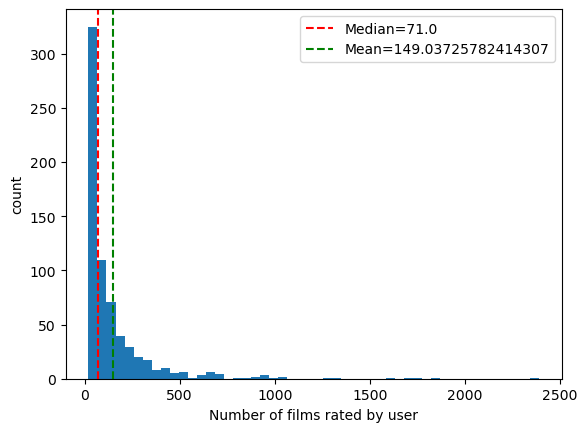

In [41]:
ratings_group_by_userid = ratings.groupby('userId')
count_data = ratings.groupby('userId').count()
median = count_data.sort_values('rating')['rating'].median()
mean = count_data.sort_values('rating')['rating'].mean()
rate_temp = count_data
plt.hist(rate_temp.sort_values('rating')['rating'], bins = 50)
# plt.xlim(0, 1000)
plt.axvline(median, linestyle='dashed', color='red', label=f'Median={median}')
plt.axvline(mean, linestyle='dashed', color='green', label=f'Mean={mean}')
# plt.text(100, 700, 'Медиана', color='red')
plt.legend()
plt.xlabel('Number of films rated by user')
plt.ylabel('count')
plt.show
None

Collaborative filtering recommends to us what similar users have watched.

If a user has watched too many or too few movies, then we wont be able to say anything constructive about his preferences, therefore such a user does not fit our model.

Thus we must understand, what users we need. Lets graph a boxplot to analize the distribution.

min:20
1st quantile:37.0
median:71.0
3rd quantile:161.0
max:2391


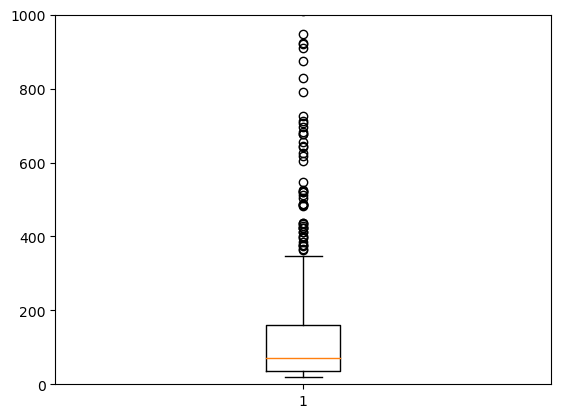

In [42]:
rate_temp = list(count_data['rating'])
stats = {
    'min': np.min(rate_temp),
    '1st quantile': np.percentile(rate_temp, 25),
    'median': np.median(rate_temp),
    '3rd quantile': np.percentile(rate_temp, 75),
    'max': np.max(rate_temp),
}
for k, v in stats.items():
    print(f'{k}:{v}')

plt.ylim(0, 1000)
plt.boxplot(rate_temp)
plt.show
None

As we can see, the majority of users has rated less that 170 movies. The minimum number of ratings for one user is 20, which is quite a lot in general (personally, i've probably rated 5 films in my entire life).

For the further steps, I will take only those users whose number of ratings is between the first and third quantile.

In [47]:
count_data = count_data.loc[(count_data['rating'] > np.percentile(rate_temp, 25)) & (count_data['rating'] < np.percentile(rate_temp, 75))]
users = list(count_data.index)

In [48]:
ratings = ratings.loc[ratings['userId'].isin(users)]

Now, to the model!!!

The algorithm is little more complex than in the conten-based recommendation system:
* First, we calculate the cosine distance of the target user's ratings with each other user's ratings. *Note: we will replace all nans with the average, and then normalize the remaining values relative to the average*
* Then we choose n users, whose preferenses are the most similar to the target user.
* After that we multiply all user ratings by the calculated similarity so that the ratings of more similar users could have a stronger influence on the final result.
* Then we compute the sum of 'weighted' ratings and then normalize it.
* The films with the highest 'normalized weighted' sums are our films to recommend.

In [49]:
def collaborative_filtering(user_id):
#   a procedure procedure for getting rid of empty values. 
    def normalize_vector(vector):
        vector_copy = np.copy(vector)
        vector_copy[np.isnan(vector_copy)] = 0
        mean = np.mean(vector_copy[np.nonzero(vector_copy)])
        vector_normalized = vector_copy - mean
        return vector_normalized
#     cosine simularity formula
    def cosine(v1, v2):
        scalar_comp = np.dot(v1, v2)
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        return scalar_comp/(norm1 * norm2)
    user_movies = list(ratings[ratings['userId'] == user_id]['movieId'])
    user_movies = list(map(str, user_movies))
    matrix_cols = ratings['movieId'].unique()
    rating_matrix = pd.DataFrame(columns = matrix_cols)
    for _, row in ratings.iterrows():
        rating_matrix.loc[row['userId'], row['movieId']] = row['rating']
    matches = [(u, cosine(normalize_vector(list(rating_matrix.loc[user_id])), normalize_vector(list(rating_matrix.loc[u])))) for u in rating_matrix.index if u != user_id]
    matches = sorted(matches, key = lambda x:x[1])
#    here we choose 10 most similar users
    maxis_match = matches[0:10]
    match_matrix = pd.DataFrame(columns = matrix_cols)
    for user, c in maxis_match:
        row = np.array(rating_matrix.loc[user]) * c
        match_matrix.loc[user] = row
#         nowmalization coef
    k = 1/sum(list(zip(*maxis_match))[1])
    match_matrix.loc['result'] = np.array(match_matrix.sum()) * k
    match_matrix = match_matrix[[x for x in rating_matrix.columns if x not in user_movies]]
    result = np.array(match_matrix.loc['result'])
    indices = np.argsort(result)[-10:]
    top_rates = result[indices]
    films = []
    for column, value in zip(match_matrix.columns, match_matrix.loc['result']):
        if value in top_rates:
            films.append(str(column))
    final = meta.loc[meta['id'].isin(films)]
    final = final['id title genres'.split()]
    final['genres'] = parse_json_column(final['genres'], "'name': '([^']*)'")

    # info about user:
    user_films = meta.loc[meta['id'].isin(user_movies)]
    g = ' '.join(list(parse_json_column(user_films['genres'], "'name': '([^']*)'")))
    g = list(set(g.split()))
    print(f'user {user_id} likes films with {g}')
    return final

In [50]:
collaborative_filtering(10)

user 10 likes films with ['fiction', 'mystery', 'family', 'history', 'romance', 'science', 'drama', 'horror', 'fantasy', 'documentary', 'thriller', 'adventure', 'crime', 'comedy', 'action']


,id,title,genres
286,527,Once Were Warriors,drama
534,858,Sleepless in Seattle,comedy drama romance
3382,593,Solaris,drama science fiction adventure mystery
4135,111,Scarface,action crime drama thriller
6388,296,Terminator 3: Rise of the Machines,action thriller science fiction
11922,2959,License to Wed,comedy


Lets test our collaborative filtering on the test user.

Our new user is really into **comedies**.

In [51]:
### example user -- likes comedies
new = pd.DataFrame({'userId':[672, 672, 672,672, 672, 672,672, 672, 672,672, 672, 672,672, 672,], 'movieId':[3, 13, 35, 68, 75, 158, 292, 343, 425, 531, 765, 788, 862, 863], 'rating':[5,5,5,5,5,5,5,5,5,5,5,5,5,5,]})
ratings = ratings.append(new, ignore_index=True)
None

C:\Users\mayko\AppData\Local\Temp\ipykernel_14500\2801683248.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ratings = ratings.append(new, ignore_index=True)


**IT IS WORKING!!!!!!!**

In [52]:
collaborative_filtering(672)

user 672 likes films with ['fiction', 'family', 'romance', 'science', 'drama', 'horror', 'fantasy', 'documentary', 'music', 'adventure', 'crime', 'comedy', 'animation']


,id,title,genres
534,858,Sleepless in Seattle,comedy drama romance
938,260,The 39 Steps,action thriller mystery
1299,377,A Nightmare on Elm Street,horror
4020,318,The Million Dollar Hotel,drama thriller
5295,4993,5 Card Stud,action western thriller
6388,296,Terminator 3: Rise of the Machines,action thriller science fiction
8546,750,Murder She Said,drama crime mystery comedy
11922,2959,License to Wed,comedy
